# 1. Crawl a real-world dataset

The data is taken from Spotify via the API, focusing on two variables: genre and audio characteristics.

## get genres from spotify api

In [69]:
import base64
from requests import post, get
import json

# App ID secret
client_id = "b3d25659b5e649e0974055d4a5cb6621"
client_secret = "620f5525b1bc4856bdc57493f4fbdb89"

# request an order
def get_token():
    auth_string = client_id + ":" + client_secret
    auth_bytes = auth_string.encode("utf-8")
    auth_base64 = str(base64.b64encode(auth_bytes), "utf-8")
    
    url = "https://accounts.spotify.com/api/token"
    headers = {
        "Authorization": "Basic " + auth_base64,
        "Content-Type": "application/x-www-form-urlencoded"
        
    }
    data = {"grant_type": "client_credentials"}
    result = post(url, headers=headers, data=data)
    json_result = json.loads(result.content)
    token = json_result["access_token"]
    return token

# Get Title
def get_auth_header(token):
    return {"Authorization": "Bearer " + token}


# Deriving the top 20 song styles in the U.S. region
def get_genres(access_token, country='US', limit=20, offset=0):
    # According to the url provided by the API
    genres_url = "https://api.spotify.com/v1/browse/categories"
    # request header
    headers = get_auth_header(access_token)
    # Request Parameters
    params = {
        "country": country,
        "limit": limit,
        'offset': offset
    }
    # Getting data
    response = get(genres_url, headers=headers, params=params)
    genres_data = response.json()
    genres = [(category['id'], category['name']) for category in genres_data['categories']['items']]

    return genres

# Initializing the Style Array
genres = []
token = get_token()

# Getting genres data
result = get_genres(token)

for genre_id, genre in result:
    genres.append(f'genre:"{genre}"')

print(genres)


['genre:"Top Lists"', 'genre:"Hip-Hop"', 'genre:"Pop"', 'genre:"Country"', 'genre:"Latin"', 'genre:"Rock"', 'genre:"Summer"', 'genre:"Workout"', 'genre:"R&B"', 'genre:"Dance/Electronic"', 'genre:"Netflix"', 'genre:"Indie"', 'genre:"Mood"', 'genre:"Sleep"', 'genre:"Christian & Gospel"', 'genre:"Regional Mexican"', 'genre:"Wellness"', 'genre:"Chill"', 'genre:"EQUAL"', 'genre:"Gaming"']


## Getting a token

In [70]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
# Get Access
client_id = "b3d25659b5e649e0974055d4a5cb6621"
client_secret = "620f5525b1bc4856bdc57493f4fbdb89"
client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)
token = get_token()


## Get 50 songs in each of the top 20 genres

In [71]:
import pandas as pd
import time

# Calculate the top 50 songs for each song style
def creat_frame(quert_list, limit):
    # Initializing the database
    data = {
        'Track ID': [],
        'Track name': [],
        'Artist': [],
        'Popularity': [],
        'Release year': [],
        'Genres': []
    }
    # Iterative genres
    for query in quert_list:
        search_result = sp.search(query, limit=limit, type='track')
        tracks = search_result['tracks']['items']

        for track in tracks:
            data['Track ID'].append(track['id'])
            data['Track name'].append(track['name'])
            data['Artist'].append(track['artists'][0]['name'])
            data['Popularity'].append(track['popularity'])
            data['Release year'].append(track['album']['release_date'][:4])
            data['Genres'].append(query)
            

    df = pd.DataFrame(data)
    return df

genres = ['genre:"Top Lists"', 'genre:"Hip-Hop"', 'genre:"Pop"', 'genre:"Country"', 'genre:"Latin"', 'genre:"Rock"', 'genre:"Summer"', 'genre:"Workout"', 'genre:"R&B"', 'genre:"Dance/Electronic"', 'genre:"Netflix"', 'genre:"Indie"', 'genre:"Mood"', 'genre:"Sleep"', 'genre:"Christian & Gospel"', 'genre:"Regional Mexican"', 'genre:"Wellness"', 'genre:"Chill"', 'genre:"EQUAL"', 'genre:"Gaming"']
df = creat_frame(genres, limit=50)
df

,Track ID,Track name,Artist,Popularity,Release year,Genres
0,4hpNQZ68Ywb1FF0u9cjpAP,That's What Rap Is About,Lazy Grey,16,2019,"genre:""Hip-Hop"""
1,5scYmJwXDkJKwZxCyZ2eJi,rubinowe wino,Kuban,59,2023,"genre:""Hip-Hop"""
2,3e5cQVJ9koKY7Rqz0aCP5j,Ken Je Dat,Jiggy Djé,28,2006,"genre:""Hip-Hop"""
3,7h0fnTCRHM4ezJA5kczoaY,Der einzige Weg,Sido,32,2016,"genre:""Hip-Hop"""
4,5Nggz0DHKZJqKnwrs924ou,Ch---- Pa------- V2 (169.706 BPM),Vegyn,48,2019,"genre:""Hip-Hop"""
...,...,...,...,...,...,...
745,44BRuSFBQwlycpn7ApWvEp,I'm Yours Tonight (feat. Brenton Mattheus & La...,Televisor,16,2013,"genre:""Gaming"""
746,4dezZc3mSUuacdpjX6FGia,Eonia,iFeature,8,2019,"genre:""Gaming"""
747,2V7VVaQQwokLZvERSD0scY,By Your Side,Weero,8,2019,"genre:""Gaming"""
748,4XFqVDaVKCjMoYdYHgJE1i,Atlantis Super Rave,Whales,13,2021,"genre:""Gaming"""


## Spectrum analysis of each song acquired

In [72]:
import time
# Getting audio features
def get_audio_features(track_id, access_token):
    audio_features_url = f'https://api.spotify.com/v1/audio-features/{track_id}'
    response = get(audio_features_url, headers=get_auth_header(token))
    
    # Avoid speed limits
    time.sleep(0.5)
    
    # Avoid frequent visits
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Failed to get audio feature. Status Code: {response.status_code}.")
    return None

In [73]:
# Retrieve Track ID
track_ids = df['Track ID'].tolist()
audio_features = []
for i in track_ids:
    audio_features.append(get_audio_features(i, token))
#     print(audio_features)

In [74]:
audio_features_df = pd.DataFrame(audio_features)

In [75]:
audio_features_df

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,0.577,0.934,0,-5.109,1,0.2420,0.0468,0.000000,0.2980,0.776,84.694,audio_features,4hpNQZ68Ywb1FF0u9cjpAP,spotify:track:4hpNQZ68Ywb1FF0u9cjpAP,https://api.spotify.com/v1/tracks/4hpNQZ68Ywb1...,https://api.spotify.com/v1/audio-analysis/4hpN...,240360,4
1,0.884,0.625,10,-7.875,0,0.2380,0.2070,0.000000,0.0984,0.406,100.016,audio_features,5scYmJwXDkJKwZxCyZ2eJi,spotify:track:5scYmJwXDkJKwZxCyZ2eJi,https://api.spotify.com/v1/tracks/5scYmJwXDkJK...,https://api.spotify.com/v1/audio-analysis/5scY...,144000,4
2,0.861,0.557,1,-7.812,1,0.2540,0.0650,0.000072,0.1710,0.710,85.472,audio_features,3e5cQVJ9koKY7Rqz0aCP5j,spotify:track:3e5cQVJ9koKY7Rqz0aCP5j,https://api.spotify.com/v1/tracks/3e5cQVJ9koKY...,https://api.spotify.com/v1/audio-analysis/3e5c...,124280,4
3,0.747,0.607,1,-8.202,1,0.1610,0.1690,0.000000,0.2590,0.453,83.993,audio_features,7h0fnTCRHM4ezJA5kczoaY,spotify:track:7h0fnTCRHM4ezJA5kczoaY,https://api.spotify.com/v1/tracks/7h0fnTCRHM4e...,https://api.spotify.com/v1/audio-analysis/7h0f...,194280,4
4,0.445,0.170,6,-17.815,1,0.0356,0.9620,0.961000,0.1800,0.348,169.452,audio_features,5Nggz0DHKZJqKnwrs924ou,spotify:track:5Nggz0DHKZJqKnwrs924ou,https://api.spotify.com/v1/tracks/5Nggz0DHKZJq...,https://api.spotify.com/v1/audio-analysis/5Ngg...,60202,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,0.676,0.754,1,-5.144,0,0.0343,0.1230,0.000005,0.1380,0.780,105.043,audio_features,44BRuSFBQwlycpn7ApWvEp,spotify:track:44BRuSFBQwlycpn7ApWvEp,https://api.spotify.com/v1/tracks/44BRuSFBQwly...,https://api.spotify.com/v1/audio-analysis/44BR...,244714,4
746,0.705,0.727,11,-3.377,1,0.1670,0.0199,0.000150,0.2920,0.488,140.091,audio_features,4dezZc3mSUuacdpjX6FGia,spotify:track:4dezZc3mSUuacdpjX6FGia,https://api.spotify.com/v1/tracks/4dezZc3mSUua...,https://api.spotify.com/v1/audio-analysis/4dez...,301714,4
747,0.563,0.797,1,-6.783,1,0.0399,0.0317,0.002990,0.0819,0.381,139.950,audio_features,2V7VVaQQwokLZvERSD0scY,spotify:track:2V7VVaQQwokLZvERSD0scY,https://api.spotify.com/v1/tracks/2V7VVaQQwokL...,https://api.spotify.com/v1/audio-analysis/2V7V...,164043,4
748,0.659,0.845,11,-2.835,0,0.3170,0.0105,0.291000,0.0582,0.337,150.094,audio_features,4XFqVDaVKCjMoYdYHgJE1i,spotify:track:4XFqVDaVKCjMoYdYHgJE1i,https://api.spotify.com/v1/tracks/4XFqVDaVKCjM...,https://api.spotify.com/v1/audio-analysis/4XFq...,230400,4


# 2. Data cleansing

By merging data genres and audio information, then removing duplicates in the middle, and finally removing interference columns.

## Merging 

In [76]:
# Merge the two tables, with the original table on the left
merged_df = df.merge(audio_features_df, left_on='Track ID', right_on='id', how='inner')
merged_df

,Track ID,Track name,Artist,Popularity,Release year,Genres,danceability,energy,key,loudness,...,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,4hpNQZ68Ywb1FF0u9cjpAP,That's What Rap Is About,Lazy Grey,16,2019,"genre:""Hip-Hop""",0.577,0.934,0,-5.109,...,0.2980,0.776,84.694,audio_features,4hpNQZ68Ywb1FF0u9cjpAP,spotify:track:4hpNQZ68Ywb1FF0u9cjpAP,https://api.spotify.com/v1/tracks/4hpNQZ68Ywb1...,https://api.spotify.com/v1/audio-analysis/4hpN...,240360,4
1,5scYmJwXDkJKwZxCyZ2eJi,rubinowe wino,Kuban,59,2023,"genre:""Hip-Hop""",0.884,0.625,10,-7.875,...,0.0984,0.406,100.016,audio_features,5scYmJwXDkJKwZxCyZ2eJi,spotify:track:5scYmJwXDkJKwZxCyZ2eJi,https://api.spotify.com/v1/tracks/5scYmJwXDkJK...,https://api.spotify.com/v1/audio-analysis/5scY...,144000,4
2,3e5cQVJ9koKY7Rqz0aCP5j,Ken Je Dat,Jiggy Djé,28,2006,"genre:""Hip-Hop""",0.861,0.557,1,-7.812,...,0.1710,0.710,85.472,audio_features,3e5cQVJ9koKY7Rqz0aCP5j,spotify:track:3e5cQVJ9koKY7Rqz0aCP5j,https://api.spotify.com/v1/tracks/3e5cQVJ9koKY...,https://api.spotify.com/v1/audio-analysis/3e5c...,124280,4
3,7h0fnTCRHM4ezJA5kczoaY,Der einzige Weg,Sido,32,2016,"genre:""Hip-Hop""",0.747,0.607,1,-8.202,...,0.2590,0.453,83.993,audio_features,7h0fnTCRHM4ezJA5kczoaY,spotify:track:7h0fnTCRHM4ezJA5kczoaY,https://api.spotify.com/v1/tracks/7h0fnTCRHM4e...,https://api.spotify.com/v1/audio-analysis/7h0f...,194280,4
4,5Nggz0DHKZJqKnwrs924ou,Ch---- Pa------- V2 (169.706 BPM),Vegyn,48,2019,"genre:""Hip-Hop""",0.445,0.170,6,-17.815,...,0.1800,0.348,169.452,audio_features,5Nggz0DHKZJqKnwrs924ou,spotify:track:5Nggz0DHKZJqKnwrs924ou,https://api.spotify.com/v1/tracks/5Nggz0DHKZJq...,https://api.spotify.com/v1/audio-analysis/5Ngg...,60202,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
767,44BRuSFBQwlycpn7ApWvEp,I'm Yours Tonight (feat. Brenton Mattheus & La...,Televisor,16,2013,"genre:""Gaming""",0.676,0.754,1,-5.144,...,0.1380,0.780,105.043,audio_features,44BRuSFBQwlycpn7ApWvEp,spotify:track:44BRuSFBQwlycpn7ApWvEp,https://api.spotify.com/v1/tracks/44BRuSFBQwly...,https://api.spotify.com/v1/audio-analysis/44BR...,244714,4
768,4dezZc3mSUuacdpjX6FGia,Eonia,iFeature,8,2019,"genre:""Gaming""",0.705,0.727,11,-3.377,...,0.2920,0.488,140.091,audio_features,4dezZc3mSUuacdpjX6FGia,spotify:track:4dezZc3mSUuacdpjX6FGia,https://api.spotify.com/v1/tracks/4dezZc3mSUua...,https://api.spotify.com/v1/audio-analysis/4dez...,301714,4
769,2V7VVaQQwokLZvERSD0scY,By Your Side,Weero,8,2019,"genre:""Gaming""",0.563,0.797,1,-6.783,...,0.0819,0.381,139.950,audio_features,2V7VVaQQwokLZvERSD0scY,spotify:track:2V7VVaQQwokLZvERSD0scY,https://api.spotify.com/v1/tracks/2V7VVaQQwokL...,https://api.spotify.com/v1/audio-analysis/2V7V...,164043,4
770,4XFqVDaVKCjMoYdYHgJE1i,Atlantis Super Rave,Whales,13,2021,"genre:""Gaming""",0.659,0.845,11,-2.835,...,0.0582,0.337,150.094,audio_features,4XFqVDaVKCjMoYdYHgJE1i,spotify:track:4XFqVDaVKCjMoYdYHgJE1i,https://api.spotify.com/v1/tracks/4XFqVDaVKCjM...,https://api.spotify.com/v1/audio-analysis/4XFq...,230400,4


## De-duplication

In [77]:
# de-duplication
uni_df = merged_df.drop_duplicates(subset='Track ID', keep='first')

In [78]:
uni_df

,Track ID,Track name,Artist,Popularity,Release year,Genres,danceability,energy,key,loudness,...,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,4hpNQZ68Ywb1FF0u9cjpAP,That's What Rap Is About,Lazy Grey,16,2019,"genre:""Hip-Hop""",0.577,0.934,0,-5.109,...,0.2980,0.776,84.694,audio_features,4hpNQZ68Ywb1FF0u9cjpAP,spotify:track:4hpNQZ68Ywb1FF0u9cjpAP,https://api.spotify.com/v1/tracks/4hpNQZ68Ywb1...,https://api.spotify.com/v1/audio-analysis/4hpN...,240360,4
1,5scYmJwXDkJKwZxCyZ2eJi,rubinowe wino,Kuban,59,2023,"genre:""Hip-Hop""",0.884,0.625,10,-7.875,...,0.0984,0.406,100.016,audio_features,5scYmJwXDkJKwZxCyZ2eJi,spotify:track:5scYmJwXDkJKwZxCyZ2eJi,https://api.spotify.com/v1/tracks/5scYmJwXDkJK...,https://api.spotify.com/v1/audio-analysis/5scY...,144000,4
2,3e5cQVJ9koKY7Rqz0aCP5j,Ken Je Dat,Jiggy Djé,28,2006,"genre:""Hip-Hop""",0.861,0.557,1,-7.812,...,0.1710,0.710,85.472,audio_features,3e5cQVJ9koKY7Rqz0aCP5j,spotify:track:3e5cQVJ9koKY7Rqz0aCP5j,https://api.spotify.com/v1/tracks/3e5cQVJ9koKY...,https://api.spotify.com/v1/audio-analysis/3e5c...,124280,4
3,7h0fnTCRHM4ezJA5kczoaY,Der einzige Weg,Sido,32,2016,"genre:""Hip-Hop""",0.747,0.607,1,-8.202,...,0.2590,0.453,83.993,audio_features,7h0fnTCRHM4ezJA5kczoaY,spotify:track:7h0fnTCRHM4ezJA5kczoaY,https://api.spotify.com/v1/tracks/7h0fnTCRHM4e...,https://api.spotify.com/v1/audio-analysis/7h0f...,194280,4
4,5Nggz0DHKZJqKnwrs924ou,Ch---- Pa------- V2 (169.706 BPM),Vegyn,48,2019,"genre:""Hip-Hop""",0.445,0.170,6,-17.815,...,0.1800,0.348,169.452,audio_features,5Nggz0DHKZJqKnwrs924ou,spotify:track:5Nggz0DHKZJqKnwrs924ou,https://api.spotify.com/v1/tracks/5Nggz0DHKZJq...,https://api.spotify.com/v1/audio-analysis/5Ngg...,60202,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
767,44BRuSFBQwlycpn7ApWvEp,I'm Yours Tonight (feat. Brenton Mattheus & La...,Televisor,16,2013,"genre:""Gaming""",0.676,0.754,1,-5.144,...,0.1380,0.780,105.043,audio_features,44BRuSFBQwlycpn7ApWvEp,spotify:track:44BRuSFBQwlycpn7ApWvEp,https://api.spotify.com/v1/tracks/44BRuSFBQwly...,https://api.spotify.com/v1/audio-analysis/44BR...,244714,4
768,4dezZc3mSUuacdpjX6FGia,Eonia,iFeature,8,2019,"genre:""Gaming""",0.705,0.727,11,-3.377,...,0.2920,0.488,140.091,audio_features,4dezZc3mSUuacdpjX6FGia,spotify:track:4dezZc3mSUuacdpjX6FGia,https://api.spotify.com/v1/tracks/4dezZc3mSUua...,https://api.spotify.com/v1/audio-analysis/4dez...,301714,4
769,2V7VVaQQwokLZvERSD0scY,By Your Side,Weero,8,2019,"genre:""Gaming""",0.563,0.797,1,-6.783,...,0.0819,0.381,139.950,audio_features,2V7VVaQQwokLZvERSD0scY,spotify:track:2V7VVaQQwokLZvERSD0scY,https://api.spotify.com/v1/tracks/2V7VVaQQwokL...,https://api.spotify.com/v1/audio-analysis/2V7V...,164043,4
770,4XFqVDaVKCjMoYdYHgJE1i,Atlantis Super Rave,Whales,13,2021,"genre:""Gaming""",0.659,0.845,11,-2.835,...,0.0582,0.337,150.094,audio_features,4XFqVDaVKCjMoYdYHgJE1i,spotify:track:4XFqVDaVKCjMoYdYHgJE1i,https://api.spotify.com/v1/tracks/4XFqVDaVKCjM...,https://api.spotify.com/v1/audio-analysis/4XFq...,230400,4


## Removal of interfering terms

In [79]:
# Removing useless data
drop_need = ['id', 'uri', 'track_href', 'analysis_url', 'type']
uni_df = uni_df.drop(columns=drop_need, axis=1)

In [80]:
# Renumbering of data
uni_df.reset_index(drop=True, inplace=True)


In [81]:
uni_df

,Track ID,Track name,Artist,Popularity,Release year,Genres,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,4hpNQZ68Ywb1FF0u9cjpAP,That's What Rap Is About,Lazy Grey,16,2019,"genre:""Hip-Hop""",0.577,0.934,0,-5.109,1,0.2420,0.0468,0.000000,0.2980,0.776,84.694,240360,4
1,5scYmJwXDkJKwZxCyZ2eJi,rubinowe wino,Kuban,59,2023,"genre:""Hip-Hop""",0.884,0.625,10,-7.875,0,0.2380,0.2070,0.000000,0.0984,0.406,100.016,144000,4
2,3e5cQVJ9koKY7Rqz0aCP5j,Ken Je Dat,Jiggy Djé,28,2006,"genre:""Hip-Hop""",0.861,0.557,1,-7.812,1,0.2540,0.0650,0.000072,0.1710,0.710,85.472,124280,4
3,7h0fnTCRHM4ezJA5kczoaY,Der einzige Weg,Sido,32,2016,"genre:""Hip-Hop""",0.747,0.607,1,-8.202,1,0.1610,0.1690,0.000000,0.2590,0.453,83.993,194280,4
4,5Nggz0DHKZJqKnwrs924ou,Ch---- Pa------- V2 (169.706 BPM),Vegyn,48,2019,"genre:""Hip-Hop""",0.445,0.170,6,-17.815,1,0.0356,0.9620,0.961000,0.1800,0.348,169.452,60202,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
734,44BRuSFBQwlycpn7ApWvEp,I'm Yours Tonight (feat. Brenton Mattheus & La...,Televisor,16,2013,"genre:""Gaming""",0.676,0.754,1,-5.144,0,0.0343,0.1230,0.000005,0.1380,0.780,105.043,244714,4
735,4dezZc3mSUuacdpjX6FGia,Eonia,iFeature,8,2019,"genre:""Gaming""",0.705,0.727,11,-3.377,1,0.1670,0.0199,0.000150,0.2920,0.488,140.091,301714,4
736,2V7VVaQQwokLZvERSD0scY,By Your Side,Weero,8,2019,"genre:""Gaming""",0.563,0.797,1,-6.783,1,0.0399,0.0317,0.002990,0.0819,0.381,139.950,164043,4
737,4XFqVDaVKCjMoYdYHgJE1i,Atlantis Super Rave,Whales,13,2021,"genre:""Gaming""",0.659,0.845,11,-2.835,0,0.3170,0.0105,0.291000,0.0582,0.337,150.094,230400,4


In [82]:
drop_columns = ['Track ID', 'duration_ms', 'time_signature']
# Remove irrelevant columns
final_df = uni_df.drop(columns=drop_columns)
final_df

,Track name,Artist,Popularity,Release year,Genres,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,That's What Rap Is About,Lazy Grey,16,2019,"genre:""Hip-Hop""",0.577,0.934,0,-5.109,1,0.2420,0.0468,0.000000,0.2980,0.776,84.694
1,rubinowe wino,Kuban,59,2023,"genre:""Hip-Hop""",0.884,0.625,10,-7.875,0,0.2380,0.2070,0.000000,0.0984,0.406,100.016
2,Ken Je Dat,Jiggy Djé,28,2006,"genre:""Hip-Hop""",0.861,0.557,1,-7.812,1,0.2540,0.0650,0.000072,0.1710,0.710,85.472
3,Der einzige Weg,Sido,32,2016,"genre:""Hip-Hop""",0.747,0.607,1,-8.202,1,0.1610,0.1690,0.000000,0.2590,0.453,83.993
4,Ch---- Pa------- V2 (169.706 BPM),Vegyn,48,2019,"genre:""Hip-Hop""",0.445,0.170,6,-17.815,1,0.0356,0.9620,0.961000,0.1800,0.348,169.452
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
734,I'm Yours Tonight (feat. Brenton Mattheus & La...,Televisor,16,2013,"genre:""Gaming""",0.676,0.754,1,-5.144,0,0.0343,0.1230,0.000005,0.1380,0.780,105.043
735,Eonia,iFeature,8,2019,"genre:""Gaming""",0.705,0.727,11,-3.377,1,0.1670,0.0199,0.000150,0.2920,0.488,140.091
736,By Your Side,Weero,8,2019,"genre:""Gaming""",0.563,0.797,1,-6.783,1,0.0399,0.0317,0.002990,0.0819,0.381,139.950
737,Atlantis Super Rave,Whales,13,2021,"genre:""Gaming""",0.659,0.845,11,-2.835,0,0.3170,0.0105,0.291000,0.0582,0.337,150.094


# 3. Write the CSV file

In [83]:
# Write data to CSV file
final_df.to_csv('output.csv', index=False)

# 4. Perform exploratory analysis

An average of the genre's song popularity is calculated to obtain `popularity_genre`, order the top ten genres, and then present them as a histogram.

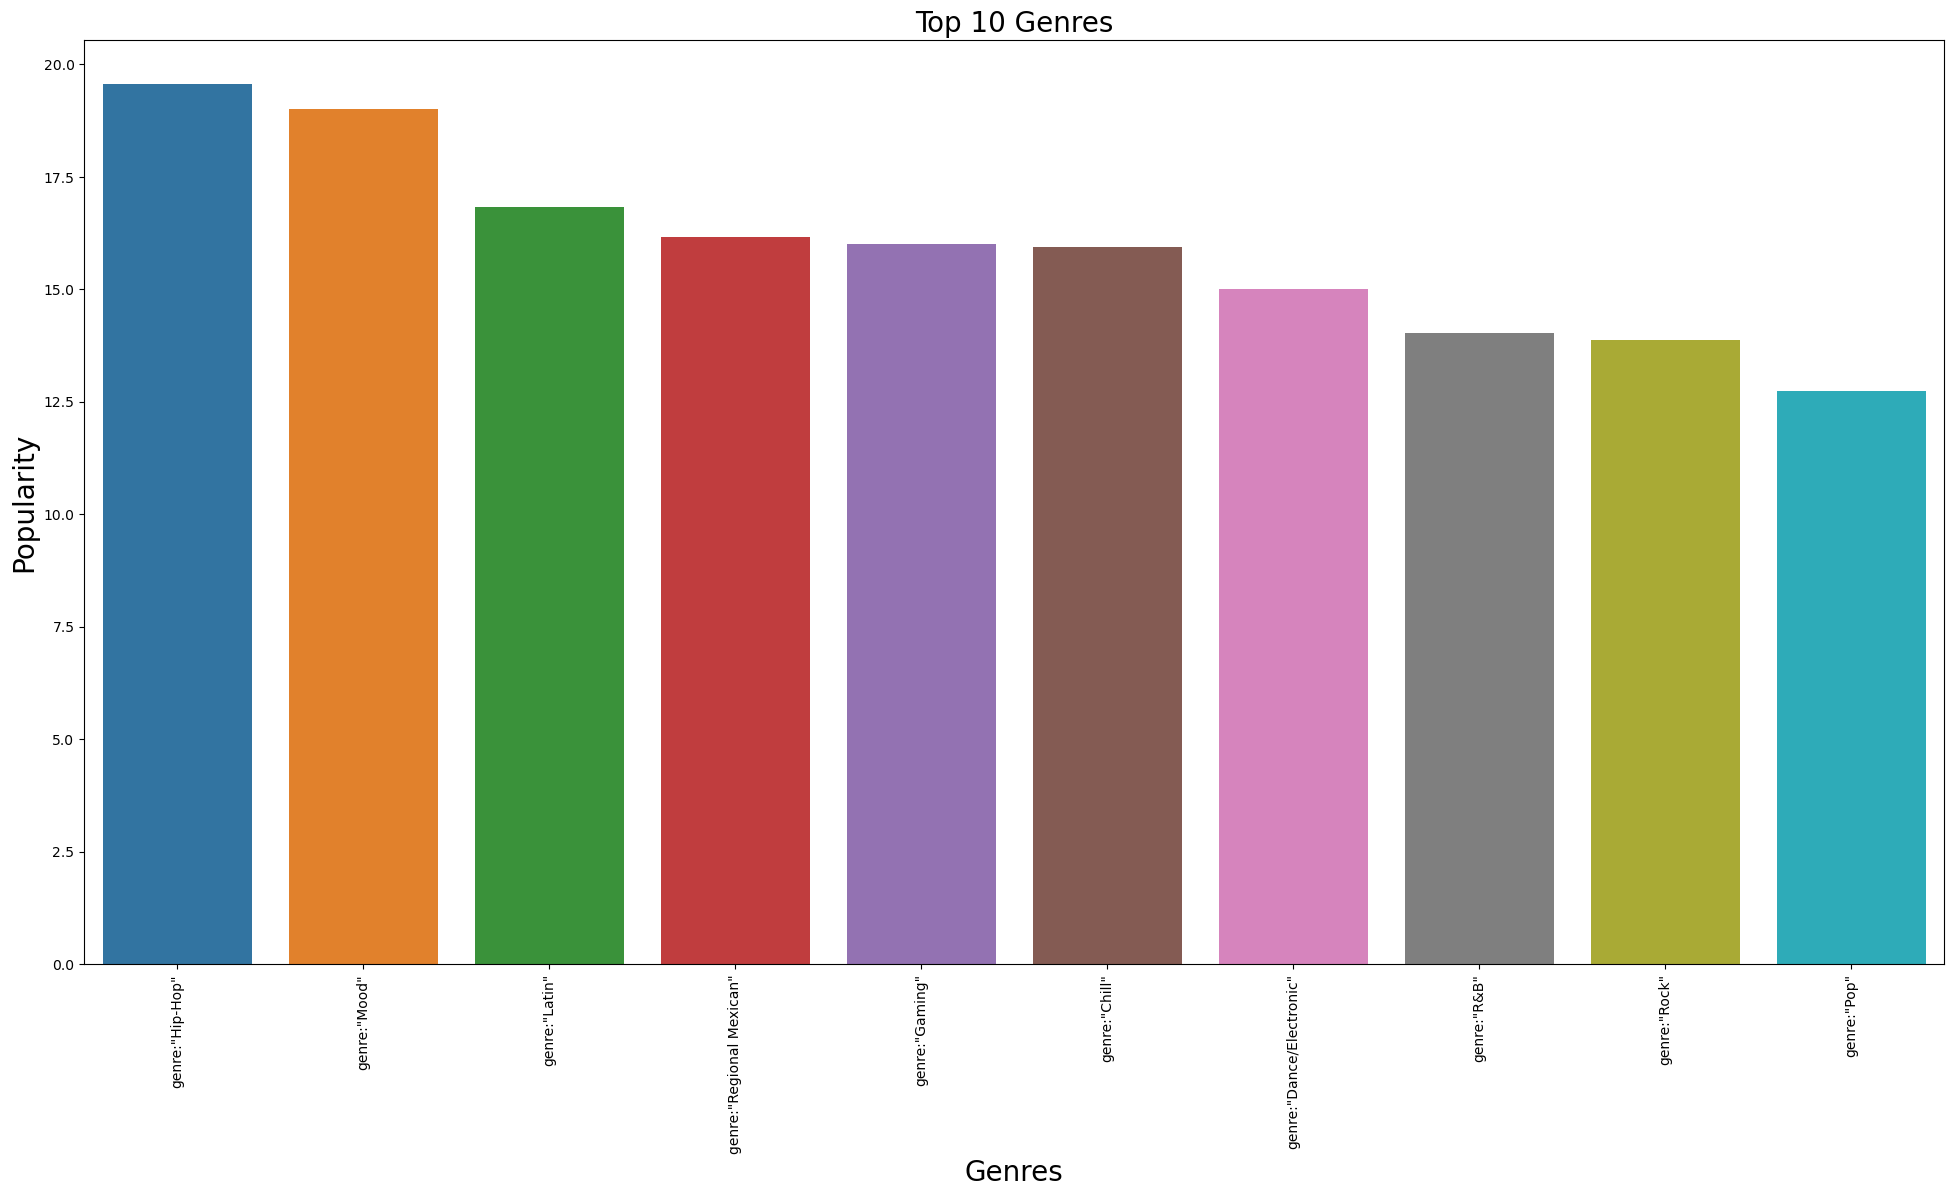

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the average score for each genre
popularity_genre = uni_df.groupby('Genres')['Popularity'].mean().reset_index()

# Average scores obtained by sorting in descending order
popularity_genre = popularity_genre.sort_values('Popularity', ascending=False)

# Selection of top 10 data
popularity_top = popularity_genre.head(10)

# Setting the canvas size
plt.figure(figsize=(24,12))

# Plotting histograms, setting axes and values
sns.barplot(x='Genres', y='Popularity', data=popularity_top)
plt.xlabel('Genres', fontsize=20)
plt.ylabel('Popularity', fontsize=20)

# Setting the title
plt.title('Top 10 Genres',fontsize=20)

# Rotate x-axis labels to avoid overlap
plt.xticks(rotation=90)

plt.show()

C:\Users\samuel\AppData\Local\Temp\ipykernel_21524\1799381556.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  network_data = final_df.groupby('Genres').mean()[features]


<Figure size 1200x800 with 0 Axes>

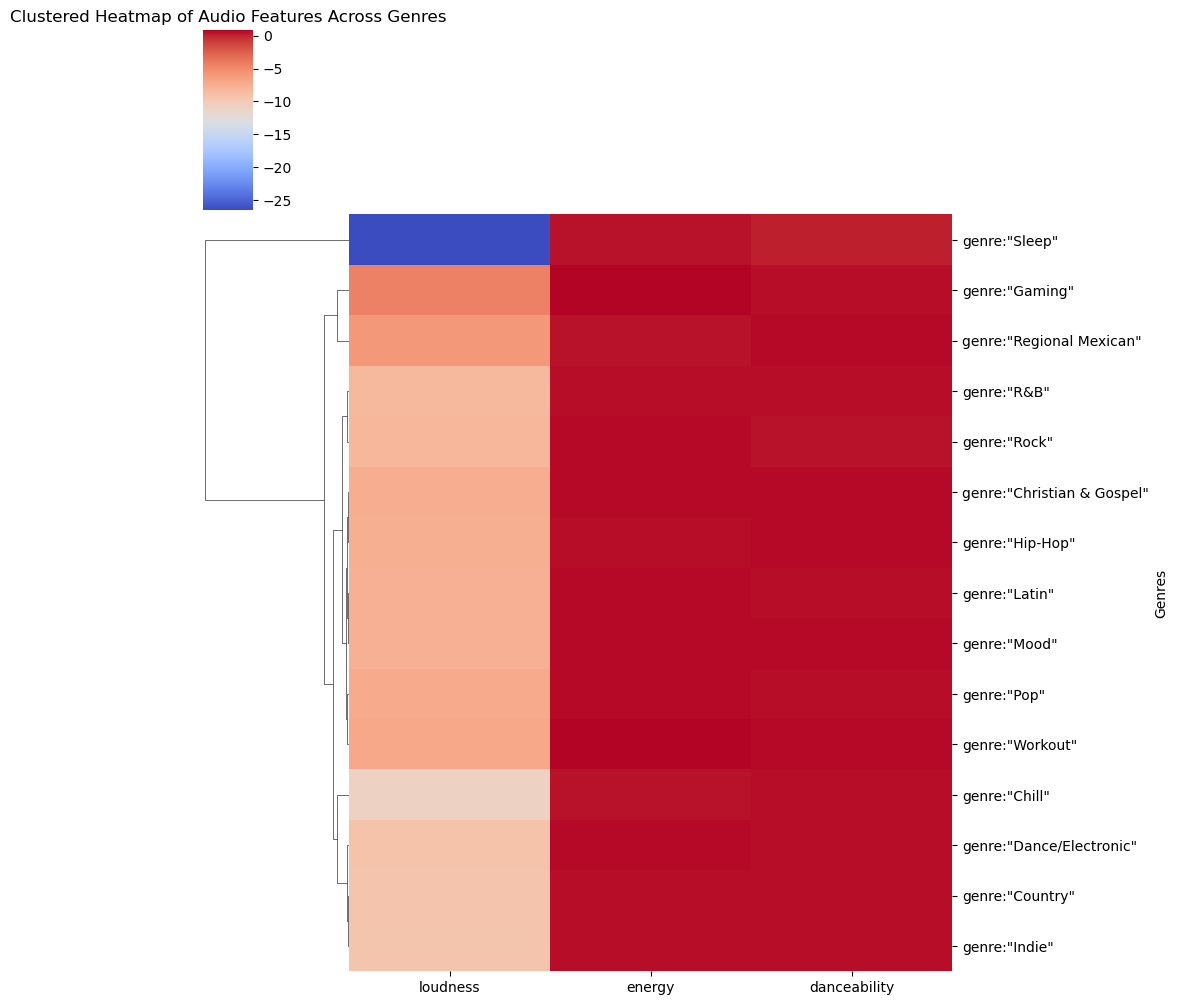

In [85]:
plt.figure(figsize=(12, 8))
network_data = final_df.groupby('Genres').mean()[features]
sns.clustermap(network_data, cmap='coolwarm', method='average', col_cluster=False)
plt.title('Clustered Heatmap of Audio Features Across Genres')
plt.show()

### Answer: As you can see from the histogram the genre with the highest popularity is hip-hop

# 5. Question

## Question 1: How to analyze the time evolution of different genres?

C:\Users\samuel\AppData\Local\Temp\ipykernel_21524\2808878928.py:10: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  matrix = year_genre_popularity.pivot('Release year',  'Genres', 'Popularity')


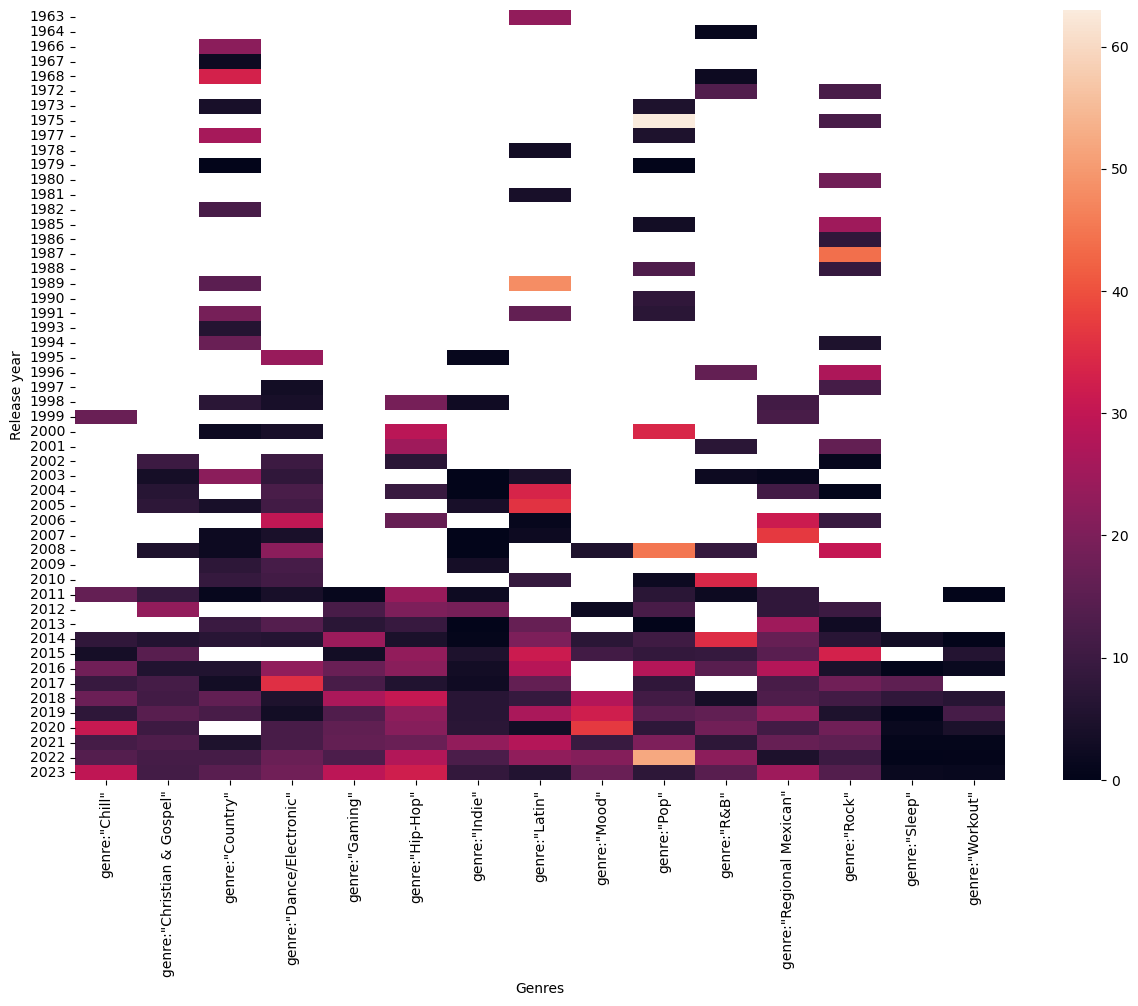

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns


# Grouping of years to prevent overlap
final_df['Release year'] = final_df['Release year'].astype(int)
# Grouping by year and style and calculating popularity for each group
year_genre_popularity = final_df.groupby(['Release year', 'Genres'])['Popularity'].mean().reset_index()
# print(year_genre_popularity)
matrix = year_genre_popularity.pivot('Release year',  'Genres', 'Popularity')
plt.figure(figsize=(15,10))
sns.heatmap(matrix)
plt.show()

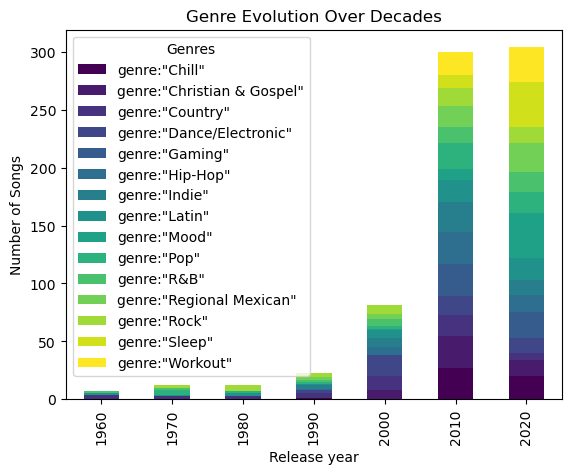

In [87]:
final_df['Release year'] = (final_df['Release year'] // 10) * 10
genre_counts = final_df.groupby(['Release year', 'Genres']).size().unstack().fillna(0)

# 绘制堆积条形图
genre_counts.plot(kind='bar', stacked=True, colormap='viridis')

# 设置图形属性
plt.title('Genre Evolution Over Decades')
plt.xlabel('Release year')
plt.ylabel('Number of Songs')
plt.legend(title='Genres')

# 显示图形
plt.show()

### Answer: It is not difficult to see from the picture that the country genre is the earliest origin. Rock genre origin time is relatively early, but with the passage of time, Rock circulation is still very objective, you can see that Rock has been in the front end of the trend. According to the packing chart, workout is the fastest growing genre, and it can be inferred that the concept of fitness is becoming more and more popular.

## Question 2: How to analyze the emotional characteristics of listening to music?

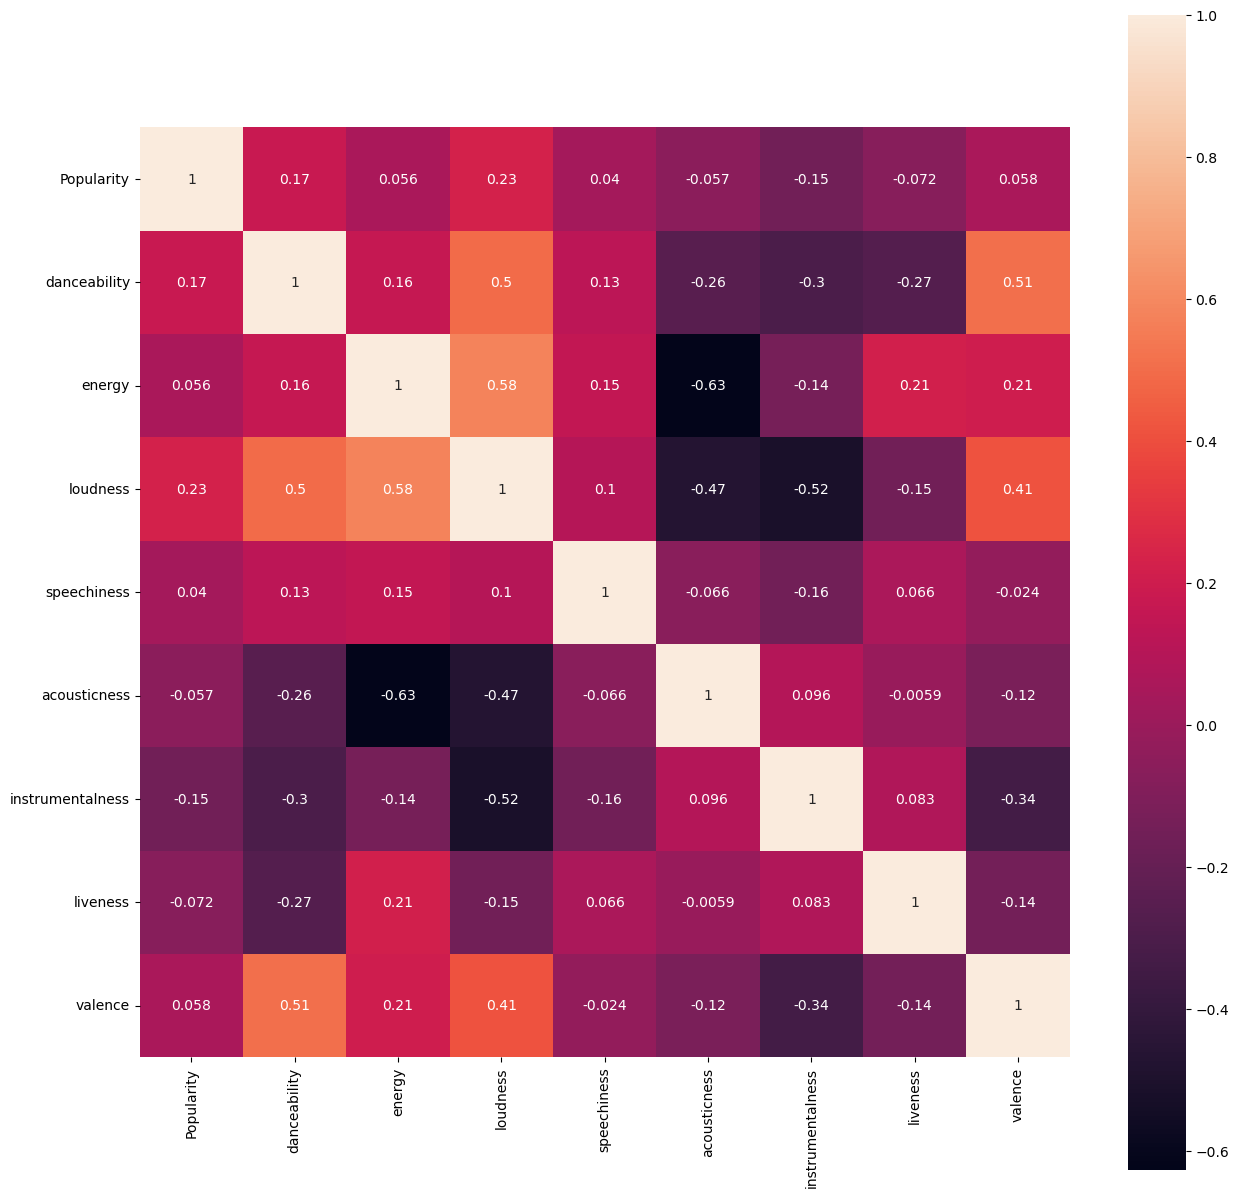

In [88]:
import seaborn as sns
import matplotlib.pyplot as plt
# Selection of features
features = ['Popularity', 'danceability', 'energy','loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence']
# Formation of the feature matrix
matrix = final_df[features].corr()
# Define image size
plt.figure(figsize=(15,15))
# Heat mapping
sns.heatmap(matrix, annot=True, square=True)
plt.show()

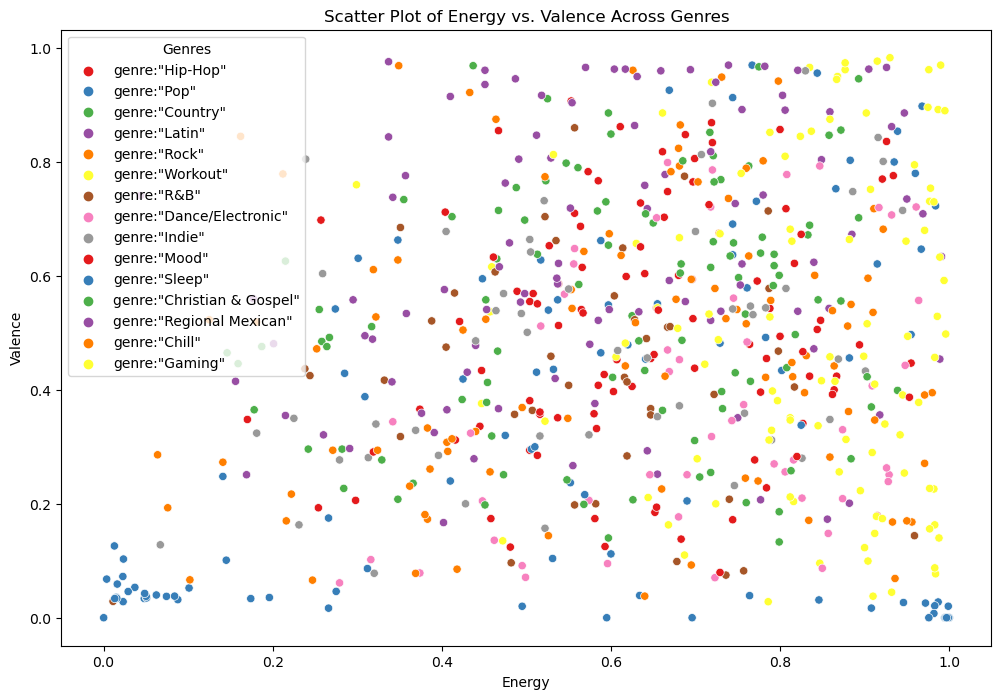

In [89]:
plt.figure(figsize=(12, 8))

# scatterplot
sns.scatterplot(x='energy', y='valence', hue='Genres', data=final_df, palette='Set1')
plt.title('Scatter Plot of Energy vs. Valence Across Genres')
plt.xlabel('Energy')
plt.ylabel('Valence')
plt.show()

### Answer:  Mood characteristics are generally correlated with the danceability, loudness and energy of a song, and the heat map shows that energy and loudness are positively correlated, proving that these two parameters can influence each other in certain situations. Meanwhile, the scatter plot neutralizes energy and positivity, so combining these two plots can determine whether songs from different genres carry a positive influence on mood. Taking workout in Genre as an example, most of the songs in the upper right corner of the scatterplot are of the workout genre, and at the same time, energy and loudness have also a relationship, so it can be assumed that songs with quite high loudness and high energy in the workout can bring better positivity. Therefore, it is recommended that fitness professionals or gyms can prepare a special workout song list to improve efficiency.

## Question 3: How to recommend songs based on user preferences？

In [90]:
import pandas as pd
from sklearn.neighbors import NearestNeighbors


# Select the columns of audio features to be considered
features = ['loudness', 'energy', 'danceability']
X = final_df[features]

# Input audio characteristics
input_features = pd.DataFrame({
    'loudness': [-5],    
    'energy': [0.9],
    'danceability': [0.7]
})

# Calculating Similarity Using the Nearest Neighbor Algorithm
k = 5  # Select the top five most similar songs
knn = NearestNeighbors(n_neighbors=k, metric='euclidean')
knn.fit(X)

# Finding the most similar songs
distances, indices = knn.kneighbors(input_features)

# Five songs with the most similar output
recommended_songs = df.iloc[indices[0]]
print(recommended_songs['Track name'])


359                                   Flat - Cepia Remix
267    I Can't Help Myself (Sugar Pie Honey Bunch) - ...
703                                             I'm Back
479                                        Close To Hell
61                         Bad Habits - Joel Corry Remix
Name: Track name, dtype: object


### As shown in the above code, it is only necessary to enter the relevant values according to the specific characteristics and perform K clustering calculation to find the recommended music. This can also be extended to analyze the user's listening habits, analyze the relevant characteristics, and finally deliver the music according to the characteristic value.

# Summary

### Learned

1. The process of the task allows you to familiarize yourself with requests for data or web pages through requests to the API.
2. During the task, problems will inevitably occur, and I can improve my error-correcting ability by constantly adjusting parameters.
3. The API request process needs to be speed-limited, which should be used in most programs.
4. The obtained data will be cleaned to avoid interfering with the project
5. Understand the underlying logic of recommender systems.

### Future work

It can be considered to learn users' love of listening to songs, analyze the audio characteristics of users' preferences, and then recommend users through clustering algorithm in combination with the audio characteristics of popular songs, so as to provide user favorability of products.